In [1]:
from tiatoolbox.wsicore.wsireader import WSIReader
from tissue_masker_lite import get_mask
import matplotlib.pyplot as plt
import numpy as np

|2024-04-24|14:39:23.837| [WARNING] /home/u1910100/miniconda3/envs/TIAToolBox/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()

|2024-04-24|14:39:23.838| [WARNING] /home/u1910100/miniconda3/envs/TIAToolBox/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details

In [2]:
#  Define path to input WSI
input_wsi = "/home/u1910100/Documents/tcga/test/vis/slides/TCGA-A4-7288-01Z-00-DX1.48597193-160b-486a-9711-f26d24dabeb5.svs"
# input_wsi = "/Users/wildsquirrel/Library/CloudStorage/OneDrive-UniversityofWarwick/tissue_mask_demo_wsi/TCGA-08-0518-01Z-00-DX8.01f2c18c-09a8-4837-8619-62f1c9b82669.svs"

# 1. Generate tissue mask using Tiatoolbox default method "otsu"

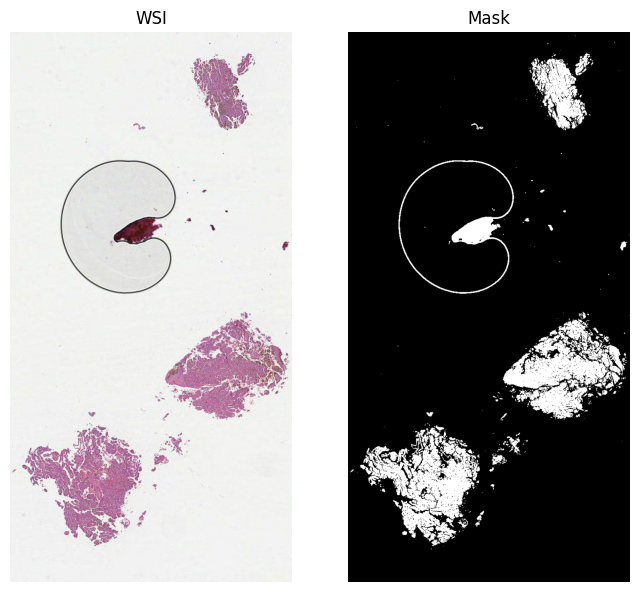

In [11]:
reader = WSIReader.open(input_wsi)
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
mask_old = reader.tissue_mask(method="otsu").slide_thumbnail()
mask_old = np.where(mask_old >= 0.5, 1, 0)
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
axes[0].imshow(thumbnail)
axes[0].title.set_text("WSI")
axes[0].axis("off")
axes[1].imshow(mask_old, cmap="gray")
axes[1].title.set_text("Mask")
axes[1].axis("off")
plt.show()

# 2. Generate tissue mask using Tiatoolbox method "morphological"

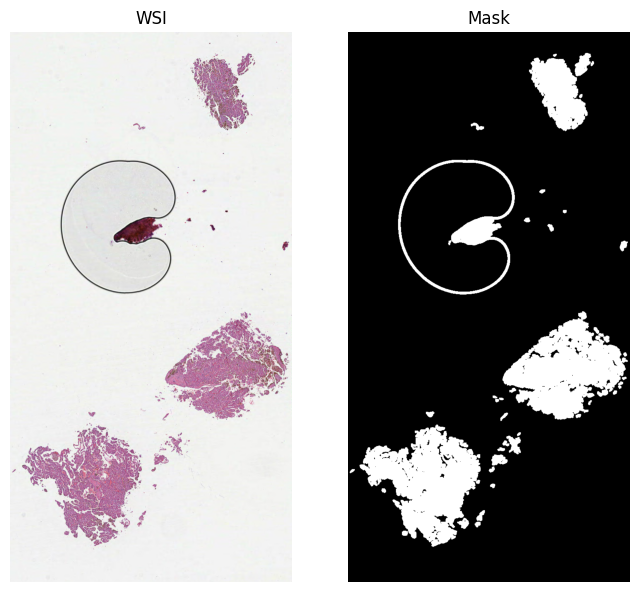

In [12]:
reader = WSIReader.open(input_wsi)
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
mask_old = reader.tissue_mask(method="morphological").slide_thumbnail()
mask_old = np.where(mask_old >= 0.5, 1, 0)
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
axes[0].imshow(thumbnail)
axes[0].title.set_text("WSI")
axes[0].axis("off")
axes[1].imshow(mask_old, cmap="gray")
axes[1].title.set_text("Mask")
axes[1].axis("off")
plt.show()

## 2. Generate tissue mask using our light weight model

'Processing TCGA-A4-7288-01Z-00-DX1.48597193-160b-486a-9711-f26d24dabeb5.svs'
'Loading model to cuda'


  0%|          | 0/66 [00:00<?, ?it/s]

'Task finished successfully'
{'objective_power': 40.0, 'slide_dimensions': (21103, 41154), 'level_count': 3, 'level_dimensions': ((21103, 41154), (5275, 10288), (1318, 2572)), 'level_downsamples': [1.0, 4.0003815608116575, 16.006079242549035], 'vendor': 'aperio', 'mpp': (0.252, 0.252), 'file_path': PosixPath('/home/u1910100/Documents/tcga/test/vis/slides/TCGA-A4-7288-01Z-00-DX1.48597193-160b-486a-9711-f26d24dabeb5.svs'), 'axes': 'YXS'}


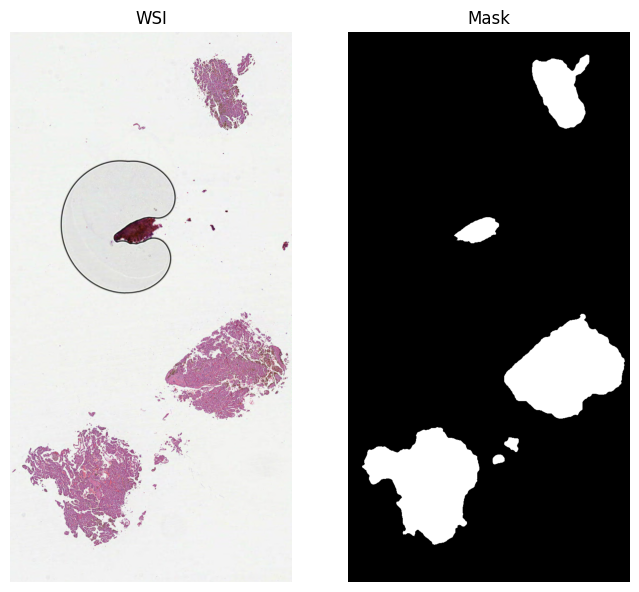

In [3]:
save_dir = "./output"
model_weight_path = "tissue_masker_lite/model_weights/model_22.pth"
mask = get_mask(
    wsi_path=input_wsi,
    save_dir=save_dir,
    model_weight=model_weight_path,
    threshold=0.5,
    device="cuda",
    return_mask=True,
    save_mask=False,
)
reader = WSIReader.open(input_wsi)
print(reader.info.as_dict())
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
axes[0].imshow(thumbnail)
axes[0].title.set_text("WSI")
axes[0].axis("off")
axes[1].imshow(mask, cmap="gray")
axes[1].title.set_text("Mask")
axes[1].axis("off")
plt.show()

# 4. Generate tissue mask using tiatoolbox pretained model "fcn-tissue_mask"

Process Batch: 100%|##########################| 231/231 [00:50<00:00,  4.54it/s]

|2024-04-23|16:47:02.221| [INFO] Finish: 0
|2024-04-23|16:47:02.222| [INFO] --Input: /home/u1910100/Documents/tcga/test/vis/slides/TCGA-A4-7288-01Z-00-DX1.48597193-160b-486a-9711-f26d24dabeb5.svs
|2024-04-23|16:47:02.222| [INFO] --Output: /home/u1910100/GitHub/tissue_masker_lite/sample_tile_results/0


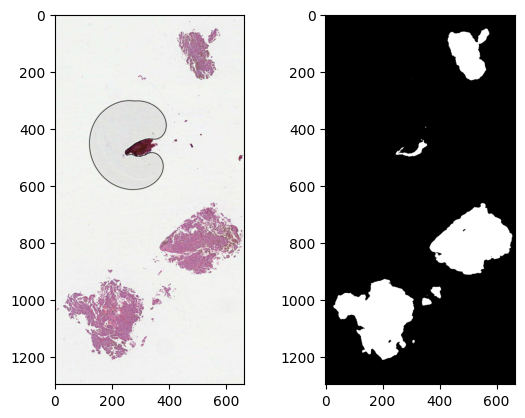

In [14]:
from tiatoolbox.models.engine.semantic_segmentor import (
    SemanticSegmentor,
    IOSegmentorConfig,
)
import shutil

tissue_segmentor = SemanticSegmentor(
    pretrained_model="fcn-tissue_mask",
    num_loader_workers=1,
    batch_size=1,
    auto_generate_mask=False,
)

tissue_segmentor_config = IOSegmentorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 2}],
    output_resolutions=[{"units": "mpp", "resolution": 2}],
    patch_input_shape=[1024, 1024],
    patch_output_shape=[512, 512],
    stride_shape=[256, 256],
    save_resolution={"units": "mpp", "resolution": 8},
)


wsi_path = input_wsi
shutil.rmtree("sample_tile_results/", ignore_errors=True)
output = tissue_segmentor.predict(
    [wsi_path],
    save_dir="sample_tile_results/",
    mode="wsi",
    ioconfig=tissue_segmentor_config,
    on_gpu=True,
    crash_on_exception=True,
)

wsi_prediction_raw = np.load(
    "sample_tile_results/0.raw.0.npy",
)  # Loading the first prediction [0] based on the output address [1]

# Simple processing of the raw prediction to generate semantic segmentation task
wsi_prediction = np.argmax(
    wsi_prediction_raw,
    axis=-1,
)
# [WSI overview extraction]
# Now reading the WSI to extract it's overview
wsi = WSIReader.open(wsi_path)

# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = tissue_segmentor_config.save_resolution

# extracting slide overview using `slide_thumbnail` method
wsi_overview = wsi.slide_thumbnail(
    resolution=overview_info["resolution"],
    units=overview_info["units"],
)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(wsi_overview)
axes[1].imshow(wsi_prediction, cmap="gray")
plt.show()